## Импорт библиотек
Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely.ops import cascaded_union
import contextily as cx


from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier

import lightgbm as lgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.metrics import mean_absolute_error, make_scorer, f1_score

from tensorflow import keras
from tensorflow.keras.optimizers import Adam

Init Plugin
Init Graph Optimizer
Init Kernel


Путь к данным:

In [2]:
DATA_PATH = './datasets/'
SERV_RADIUS = 1000 #метров до поликлинники по СП 42.13330.2016

## Загрузим датасеты.

### Location
**01_Location_July.csv** и **01_CLocation_July.csv** - Сгенерированный датасет о численности населения на территории Москвы и с гранулярностью по районам города Москвы и секторами 500х500 метров.

***Характер данных***: Данные об изменении численности населения на территории

***Временное разбиение***: календарный месяц

***Территориальное разбиение***: Москва, разбитая по административным районам и на сектора 500х500м.

***Перечень показателей данных в данных:***
- Количество человек, проживающих на территории района/сектора
- Количество человек, работающих на территории района/сектора
- Количество человек, которые находились на территории района/сектора по будням в дневное время чаще, чем в любых других районах/секторах, в рассматриваемый месяц
- Количество человек, проживающих на территории района/сектора и имеющих разъездную работу

In [3]:
df_loc = pd.read_csv(DATA_PATH + '01_Location_July.csv')
print(df_loc.shape)
df_loc.head(3)

(146, 5)


,zid,customers_cnt_home,customers_cnt_job,customers_cnt_day,customers_cnt_move
0,1,31723,11029,23944,1411
1,2,64780,15890,40845,3536
2,3,69098,39701,63486,4161


In [4]:
df_cloc = pd.read_csv(DATA_PATH + '01_CLocation_July.csv')
print(df_cloc.shape)
df_cloc.head(3)

(10240, 5)


,zid,customers_cnt_home,customers_cnt_job,customers_cnt_day,customers_cnt_move
0,32909,4,0,0,0
1,32910,25,8,26,0
2,33261,2,0,2,0


### Matrix_Home_Work

**04_Matrix_Home_Work_July**; **04_CMatrix_Home_Work_July.csv** - Сгенерированный датасет о динамике перемещения населения дом-работа на территории Москвы (Матрица корреспонденции дом-работа) и с гранулярностью по районам города Москвы и секторами 500х500 метров.

***Характер данных***: Данные Матрица корреспонденции дом-работа

***Временное разбиение***: календарный месяц

***Территориальное разбиение***: Москва, разбитая по административным районам и на сектора 500х500м.

***Перечень показателей данных в данных:***

- Количество человек, место проживания которых в отчетном месяце находится в районе/секторе А, а место работы - в районе/секторе В

In [5]:
df_home_work = pd.read_csv(DATA_PATH + '04_Matrix_Home_Work_July.csv')
df_chome_work = pd.read_csv(DATA_PATH + '04_CMatrix_Home_Work_July.csv')
df_chome_work.head(1)

,home_zid,work_zid,customers_cnt
0,-2,33620,2


## Административное деление районов

Загрузим так же справочник соотношения секторов 500х500м и административного деления районов Москвы

In [6]:
df_sector_rel = pd.read_csv(DATA_PATH + 'relations_between_500x500_and_MSC.csv')
df_sector_rel.head(3)

,cell_zid,area_peresechenia_s_admzone_kv.km,adm_zid,adm_name,okrug_name,sub_ter
0,32909,0.407116,216,Роговское,Троицкий административный округ,Новая Москва
1,32910,1.003458,216,Роговское,Троицкий административный округ,Новая Москва
2,33261,0.233312,216,Роговское,Троицкий административный округ,Новая Москва


In [7]:
df_sector_rel['sub_ter'].value_counts()

Новая Москва     6734
Старая Москва    6498
Name: sub_ter, dtype: int64

In [8]:
new_zid_list = df_sector_rel.query('sub_ter == "Новая Москва"')['cell_zid'].to_list()

## Загрузим геоданные

In [9]:
shp_admzones = gpd.read_file(DATA_PATH + 'admzones2021/admzones2021.shp').to_crs(epsg=32637)
shp_fishnet = gpd.read_file(DATA_PATH + 'fishnet2021/fishnet2021.shp').to_crs(epsg=32637)

In [10]:
shp_admzones.head(2)

,adm_zid,adm_name,okrug_name,sub_ter,okrug_id,area,geometry
0,519,Коломна,None,Московская область,NaN,1.728866e+09,"POLYGON ((455694.923 6079507.744, 455694.900 6..."
1,507,Дзержинский,None,Московская область,NaN,1.566430e+07,"POLYGON ((424049.408 6164789.852, 424184.970 6..."


Оставим только данные, относящиеся к Москве:

In [11]:
shp_moscow = shp_admzones[(shp_admzones['sub_ter'] == 'Старая Москва') |\
                          (shp_admzones['sub_ter'] == 'Новая Москва')]

shp_mosnet = shp_fishnet.sjoin(
    shp_moscow,
    how="inner",
    predicate='intersects').drop('index_right', axis=1)

Поместим значением `cell_zid` на место индекса, и отбросим все дублирующиеся индексы:

In [12]:
shp_mosnet = shp_mosnet.set_index('cell_zid')[~shp_mosnet.index.duplicated(keep='first')].reset_index()

In [13]:
#ax = shp_admzones.plot(figsize=(17,17), alpha=0.5)
pd.merge(
    shp_admzones,
    df_sector_rel[['cell_zid', 'adm_zid']],
    how="inner",
    on='adm_zid',
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None).head(2)
#).plot(figsize=(17,17), color='red', alpha=0.01)

#plt.show()

,adm_zid,adm_name,okrug_name,sub_ter,okrug_id,area,geometry,cell_zid
0,109,Перово,Восточный административный округ,Старая Москва,561.0,9.829908e+06,"POLYGON ((421956.761 6180023.056, 422428.189 6...",107514
1,109,Перово,Восточный административный округ,Старая Москва,561.0,9.829908e+06,"POLYGON ((421956.761 6180023.056, 422428.189 6...",107515


## Загрузим наборы данных с data.mos.ru

Загрузим наборы данных с `data.mos.ru`, а именно:

1. [Поликлиническая помощь взрослым](https://data.mos.ru/opendata/503/)
1. [Поликлиническая помощь детям](https://data.mos.ru/opendata/505/)
1. [Границы зон охраны объектов культурного наследия](https://data.mos.ru/opendata/613/)
1. [Парковые территории](https://data.mos.ru/opendata/1465)

In [14]:
df_adult = pd.read_json(DATA_PATH + 'mos_ru/503_clinic_adult.json', encoding='windows-1251')
df_child = pd.read_json(DATA_PATH + 'mos_ru/505_clinic_child.json', encoding='windows-1251')

df_zculture = pd.read_json(DATA_PATH + 'mos_ru/613_zones_culture.json', encoding='windows-1251')
df_zpark = pd.read_json(DATA_PATH + 'mos_ru/1465_zones_park.json', encoding='windows-1251')

Функция для выделения координаты из данных:

In [15]:
def coords(row):
    data = row['geoData']
    if data['type'] == 'MultiPoint':
        return Point(data['coordinates'][0][0], data['coordinates'][0][1])
    elif data['type'] == 'MultiPolygon':
        try:
            return MultiPolygon(data['coordinates'][0])
        except:
            return Polygon(data['coordinates'][0][0])
    else:
        return Polygon(data['coordinates'][0])

In [16]:
#df_adult[['longitude', 'latitude']] = df_adult.apply(coords, axis=1, result_type='expand')
df_adult['geometry'] = df_adult.apply(coords, axis=1)
df_child['geometry'] = df_child.apply(coords, axis=1)
df_zculture['geometry'] = df_zculture.apply(coords, axis=1)
df_zpark['geometry'] = df_zpark.apply(coords, axis=1)

Объединим объекты одного типа в общие DataFrame (клиники к клиникам, запретные зоны к запретным зонам)

In [17]:
df_adult['age'] = 'adult'
df_child['age'] = 'child'
df_zculture['zone_type'] = 'culture'
df_zculture['name'] = df_zculture['ObjectNameOnDoc']
df_zpark['zone_type'] = 'park'
df_zpark['name'] = df_zpark['CommonName']


df_clinic = pd.concat((df_adult, df_child))[['ShortName', 'age', 'geometry']]
df_zones = pd.concat((df_zculture, df_zpark))[['name', 'geometry']]

Создадим объекты типа **GeoDataFrame**

In [18]:
gdf_clinic = gpd.GeoDataFrame(
    df_clinic, geometry=df_clinic.geometry,
    crs="EPSG:4326").to_crs(epsg=32637)

gdf_zones = gpd.GeoDataFrame(
    df_zones, geometry=df_zones.geometry,
    crs="EPSG:4326").to_crs(epsg=32637)

Добавим буфера - зоны диаметром в зону обслуживания поликлинники в соответствии с *СП 42.13330.2016 "Градостроительство. Планировка и застройка городских и сельских поселений"*

In [19]:
clinic_buff_1k = gdf_clinic.copy()
clinic_buff_500 = gdf_clinic.copy()
clinic_buff_250 = gdf_clinic.copy()

clinic_buff_1k.geometry = gpd.GeoSeries(cascaded_union(clinic_buff_1k.geometry.buffer(SERV_RADIUS)))
clinic_buff_500.geometry = gpd.GeoSeries(cascaded_union(clinic_buff_500.geometry.buffer(SERV_RADIUS/4)))
clinic_buff_250.geometry = gpd.GeoSeries(cascaded_union(clinic_buff_250.geometry.buffer(SERV_RADIUS/8)))

Добавим данные о реальном местоположении перспективного строительства объектов здравоохранения, собранные вручную с портала [ИАИС ОГД](https://isogd.mos.ru/), для проверки работоспособности нашей модели.

In [20]:
df_extra = pd.read_csv(DATA_PATH + 'extracted_points.csv')
gdf_extra = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(df_extra['Y'], df_extra['X'], crs="EPSG:4326")).to_crs(epsg=32637)

Аналогичным образом создадим буфер

In [21]:
extra_buff_1k = gdf_extra.copy()
extra_buff_1k.geometry = gpd.GeoSeries(cascaded_union(extra_buff_1k.geometry.buffer(SERV_RADIUS)))

extra_buff_500 = gdf_extra.copy()
extra_buff_500.geometry = gpd.GeoSeries(cascaded_union(extra_buff_500.geometry.buffer(SERV_RADIUS/4)))

extra_buff_250 = gdf_extra.copy()
extra_buff_250.geometry = gpd.GeoSeries(cascaded_union(extra_buff_250.geometry.buffer(SERV_RADIUS/8)))

## Анализ

Приступим к анализу полученных данных, для начала объединим данные по численности населения с картой Москвы:

In [22]:
gdf_cloc = pd.merge(shp_mosnet,
                    df_cloc,
                    how="inner",
                    left_on='cell_zid',
                    right_on='zid',
                    sort=False,
                    suffixes=("_x", "_y"),
                    copy=True,
                    indicator=False,
                    validate=None).drop(columns='zid')

In [23]:
gdf_cloc.head(2)

,cell_zid,geometry,adm_zid,adm_name,okrug_name,sub_ter,okrug_id,area,customers_cnt_home,customers_cnt_job,customers_cnt_day,customers_cnt_move
0,32909,"POLYGON ((374654.459 6112167.888, 374665.200 6...",216,Роговское,Троицкий административный округ,Новая Москва,572.0,1.782183e+08,4,0,0,0
1,32910,"POLYGON ((375154.304 6112157.147, 375165.045 6...",216,Роговское,Троицкий административный округ,Новая Москва,572.0,1.782183e+08,25,8,26,0


In [24]:
#gdf_cloc.explore(
#    column="served", # make choropleth based on "BoroName" column
#    tooltip="served", # show "BoroName" value in tooltip (on hover)
#    popup=True, # show all values in popup (on click)
#    tiles="CartoDB positron", # use "CartoDB positron" tiles
#    cmap="Set1", # use "Set1" matplotlib colormap 
#   )

Добавим все сектора, обслуживаемые хоть одной поликлинникой

In [25]:
# Если подобную зону надо отрисовать отдельно:
#gdf_served = gpd.overlay(gdf_cloc, clinic_buff, how='intersection')[['cell_zid', 'geometry']]

served_list_1k = gpd.overlay(gdf_cloc, clinic_buff_1k, how='intersection')['cell_zid'].unique()
served_list_500 = gpd.overlay(gdf_cloc, clinic_buff_500, how='intersection')['cell_zid'].unique()
served_list_250 = gpd.overlay(gdf_cloc, clinic_buff_250, how='intersection')['cell_zid'].unique()

extra_list_1k = gpd.overlay(gdf_cloc, extra_buff_1k, how='intersection')['cell_zid'].unique()
extra_list_500 = gpd.overlay(gdf_cloc, extra_buff_500, how='intersection')['cell_zid'].unique()
extra_list_250 = gpd.overlay(gdf_cloc, extra_buff_250, how='intersection')['cell_zid'].unique()

In [26]:
gdf_cloc['served'] = np.where(gdf_cloc['cell_zid'].isin(served_list_1k), 0.25, 0)
gdf_cloc.loc[gdf_cloc['cell_zid'].isin(served_list_500), 'served'] = 0.5
gdf_cloc.loc[gdf_cloc['cell_zid'].isin(served_list_250), 'served'] = 1.0
#gdf_cloc['served'] = np.where(gdf_cloc['cell_zid'].isin(served_list_250), 1)

Отобразим часть зон обслуживания на карте:

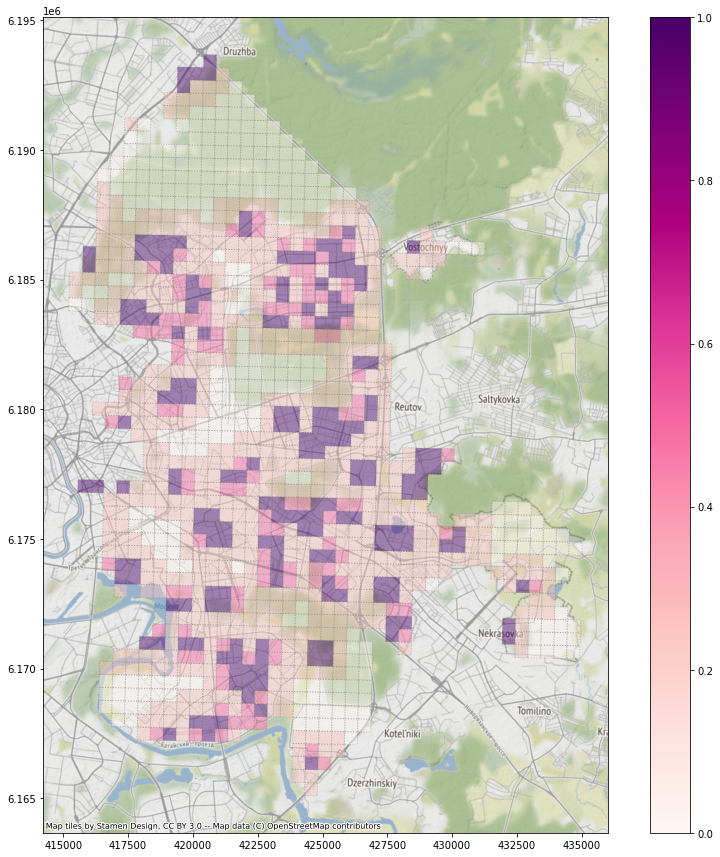

In [27]:
ax = gdf_cloc[(gdf_cloc['okrug_name'] == 'Юго-Восточный административный округ') |
              (gdf_cloc['okrug_name'] == 'Восточный административный округ')].plot(figsize=(15,15),
              linestyle=':',
              edgecolor='gray',
              column='served',
              cmap='RdPu',
              alpha = 0.45,
              legend=True)

cx.add_basemap(ax, crs=gdf_cloc.crs)

Также добавим все сектора, в которых строить нежелательно (парки, зоны культурного наследия)

In [28]:
stop_list = gpd.overlay(gdf_cloc, gdf_zones, how='intersection')['cell_zid'].unique()

gdf_cloc['blocked'] = np.where(gdf_cloc['cell_zid'].isin(stop_list), 1, 0)

Добавим новые признаки на основе среднего значения по районам:

In [29]:
mean_cloc = gdf_cloc[['adm_name',
                      'customers_cnt_home',
                      'customers_cnt_job',
                      'customers_cnt_day',
                      'customers_cnt_move']].groupby('adm_name').transform('mean').round()
mean_cloc.columns = ['mean_home', 'mean_job', 'mean_day', 'mean_move']
gdf_cloc = pd.concat([gdf_cloc, mean_cloc], axis=1)

Следовательно, относительные признаки представляют собой:

In [30]:
gdf_cloc['rel_home'] = gdf_cloc['customers_cnt_home'] / gdf_cloc['mean_home']
gdf_cloc['rel_job'] = gdf_cloc['customers_cnt_job'] / gdf_cloc['mean_job'] 
gdf_cloc['rel_day'] = gdf_cloc['customers_cnt_day'] / gdf_cloc['mean_day'] 
gdf_cloc['rel_move'] = gdf_cloc['customers_cnt_move'] / gdf_cloc['mean_move'] 

И как это выглядит на карте:

<AxesSubplot:>

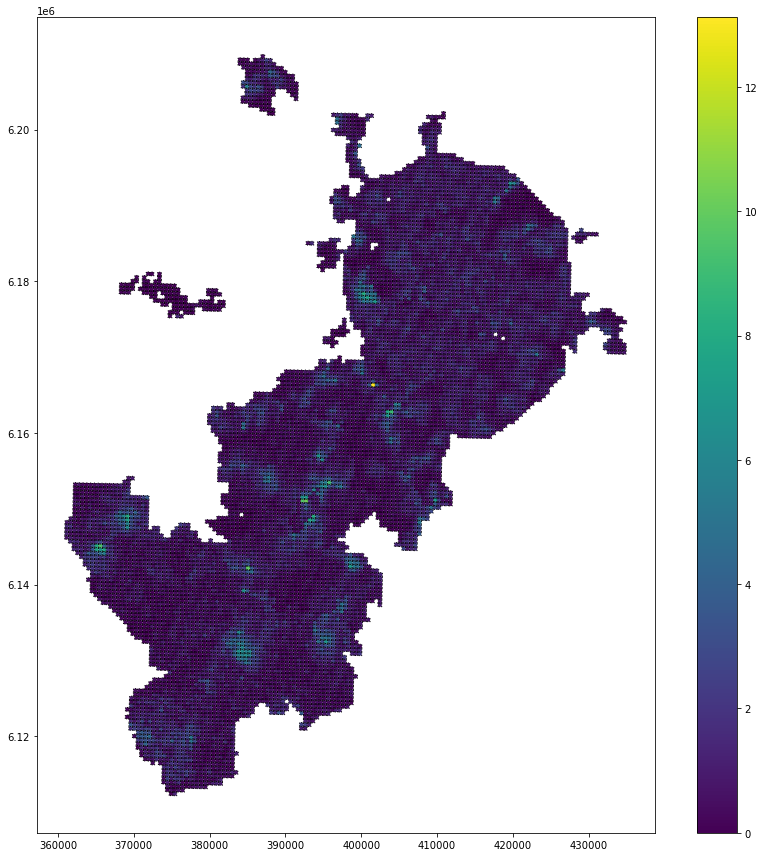

In [31]:
gdf_cloc.plot(figsize=(15,15),
                        linestyle=':',
                        edgecolor='black',
                        column='rel_day',
                        legend=True)

## Подготовка данных для модели

Подготовим наши признаки, не забыв удалить дубликаты:

In [32]:
data = gdf_cloc[['cell_zid',
                 'sub_ter',
                 'rel_home',
                 'rel_job',
                 'rel_day',
                 'rel_move',
                 'served']].drop_duplicates().copy().set_index('cell_zid')
#                 'blocked']].drop_duplicates().copy().set_index('cell_zid')

data['sub_ter'] = np.where(data['sub_ter']=='Старая Москва', 0, 1)
data = data[~data.index.duplicated(keep='first')]

Разделим на тренировочную и тестовые выборки по территориальному признаку (Старая Москва/Новая Москва):

In [33]:
train = data.loc[data['sub_ter'] == 0].drop('sub_ter', axis=1).copy()
test = data.loc[data['sub_ter'] == 1].drop('sub_ter', axis=1).reset_index().copy()

In [34]:
test['served'] = np.where(test['cell_zid'].isin(extra_list_1k), 0.25, 0)
test.loc[test['cell_zid'].isin(extra_list_500), 'served'] = 0.5
test.loc[test['cell_zid'].isin(extra_list_250), 'served'] = 1.0

In [35]:
X_train = train.copy()
X_test = test.set_index('cell_zid').copy()

y_train = X_train.pop('served')
y_test = X_test.pop('served')

## Моделирование:

### Baseline
для проверки на адекватность:

In [36]:
model = DummyRegressor(strategy='mean')

model.fit(X_train, y_train)

preds = pd.Series(model.predict(X_test), index=X_test.index, name='served')

mean_absolute_error(y_test, preds)

0.24372808452943104

### Случайный лес:

In [37]:
model = RandomForestRegressor(n_estimators=71,
                               max_depth=8,
                               n_jobs=-1,
                               random_state=13)

model.fit(X_train, y_train)

preds = pd.Series(model.predict(X_test), index=X_test.index, name='served')

mean_absolute_error(y_test, preds)

0.23218473606745496

<AxesSubplot:>

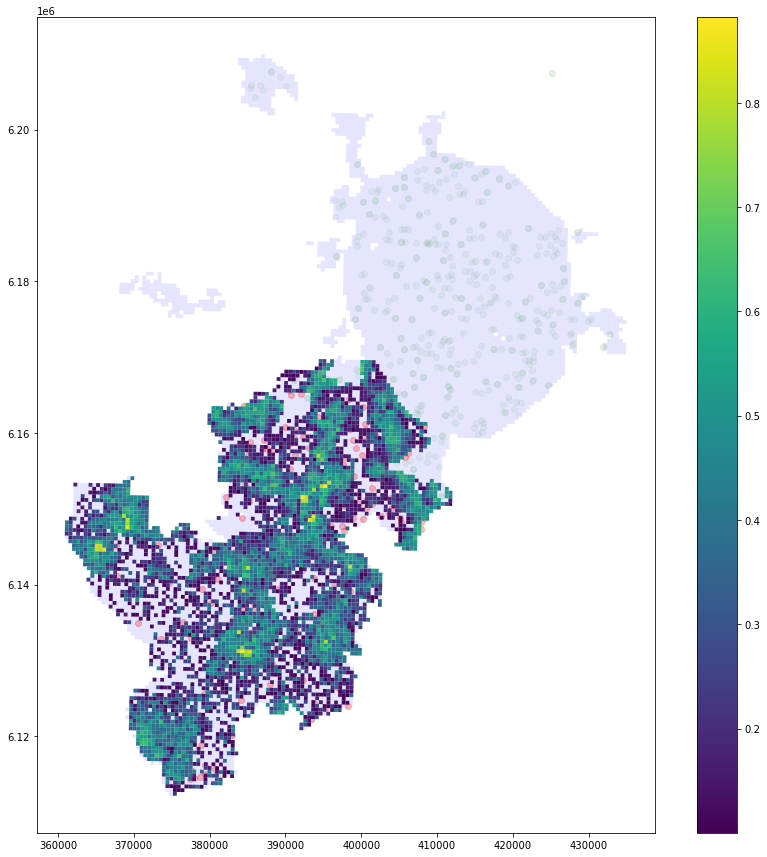

In [38]:
ax = gdf_cloc.plot(figsize=(15,15),
                   linestyle=':',
                   color='blue',
                   edgecolor='whitesmoke',
                   alpha=0.1)

gdf_extra.plot(ax=ax, color='red', alpha=0.25)
gdf_clinic.plot(ax=ax, color='green', alpha=0.05)
pd.merge(
    gdf_cloc[gdf_cloc['sub_ter']=='Новая Москва'],
    preds[preds > 0.1],
    how="inner",
    on='cell_zid').plot(ax=ax, column='served_y', legend=True)

### Градиентный спуск:

In [39]:
model = lgb.LGBMRegressor(
    boosting_type='gbdt',
    max_depth=-1,
    learning_rate=0.05,
    n_estimators=100,
    random_state=13,
    n_jobs=-1)

model.fit(X_train, y_train)

preds = pd.Series(model.predict(X_test), index=X_test.index, name='served')

mean_absolute_error(y_test, preds)

0.2223539848990244

<AxesSubplot:>

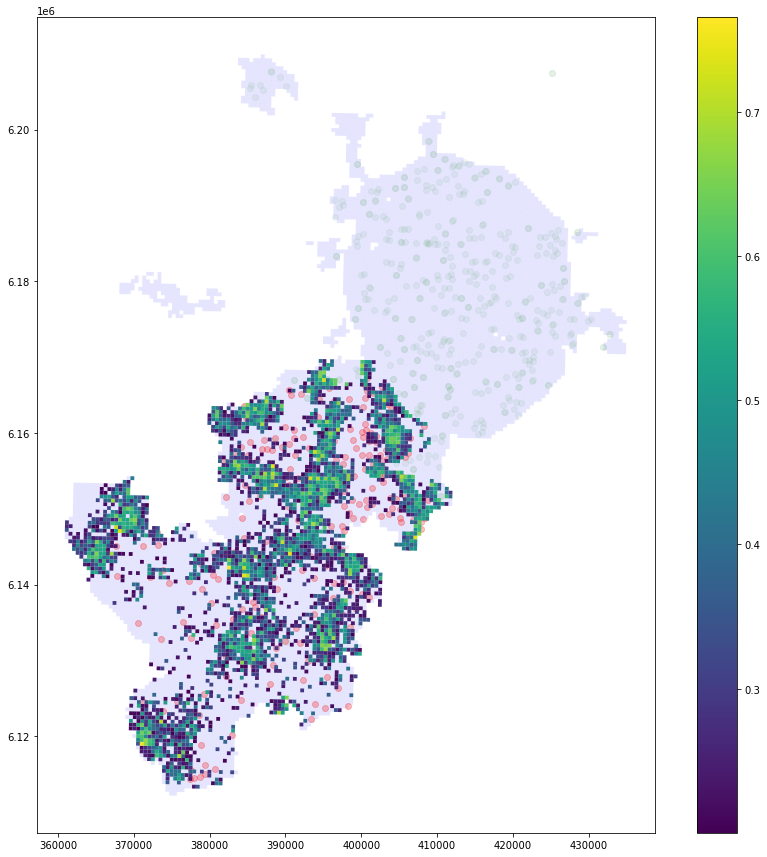

In [40]:
ax = gdf_cloc.plot(figsize=(15,15),
                   linestyle=':',
                   color='blue',
                   edgecolor='whitesmoke',
                   alpha=0.1)

gdf_extra.plot(ax=ax, color='red', alpha=0.25)
gdf_clinic.plot(ax=ax, color='green', alpha=0.05)
pd.merge(
    gdf_cloc[gdf_cloc['sub_ter']=='Новая Москва'],
    preds[preds > 0.2],
    how="inner",
    on='cell_zid').plot(ax=ax, column='served_y', legend=True)

С использованием метрики MAE - это **оптимальная модель, из проходящих проверку на адекватность**

### Keras

Также протестируем TensorFlow

In [41]:
optimizer = Adam()
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=10, input_dim=X_train.shape[1]))
model.add(keras.layers.Dense(units=1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(X_train, y_train, epochs=45, verbose=0, validation_split = 0.2)
preds = model.predict(X_test)

Metal device set to: Apple M1


2021-10-24 21:09:35.223876: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-10-24 21:09:35.223967: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-10-24 21:09:35.270630: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-24 21:09:35.270812: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-10-24 21:09:35.367620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-24 21:09:35.809812: I tensorflow/core/grappler/

In [42]:
print('MAE', mean_absolute_error(y_test, preds))
result = X_test.copy()
result['served'] = preds

MAE 0.25620066242311595


<AxesSubplot:>

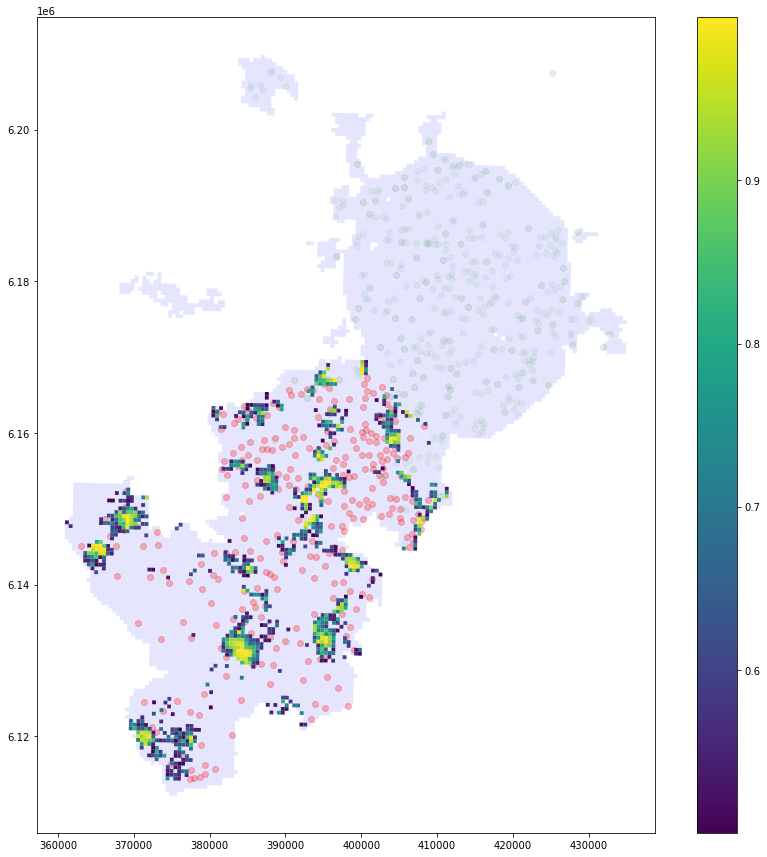

In [43]:
ax = gdf_cloc.plot(figsize=(15,15),
                   linestyle=':',
                   color='blue',
                   edgecolor='whitesmoke',
                   alpha=0.1)

gdf_extra.plot(ax=ax, color='red', alpha=0.25)
gdf_clinic.plot(ax=ax, color='green', alpha=0.05)
pd.merge(
    gdf_cloc[gdf_cloc['sub_ter']=='Новая Москва'],
    result[result['served']>0.5],
    how="inner",
    on='cell_zid').plot(ax=ax, column='served_y', legend=True)

В данном случае, KERAS не пригоден.

Экспорт результата:

In [44]:
export = gdf_cloc.to_crs(epsg=4326)

In [45]:
export.to_csv('export.csv', sep='|')